In [1]:
%matplotlib inline
import argparse
import csv
import logging
import os
import random
import sys
import pickle
import time
import numpy as np
from termcolor import colored
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from bert_util import *

In [2]:
mnli_processor = MnliProcessor()
hans_processor = HansProcessor()
train_examples = mnli_processor.get_train_examples('data/', 10000)
test_examples = hans_processor.get_test_examples('data/')

In [3]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
train_examples_tokens = []
for te in train_examples:
    train_examples_tokens.append(["[CLS]"] + bert_tokenizer.tokenize(te.text_a) + ["[SEP]"] + bert_tokenizer.tokenize(te.text_b) + ["[SEP]"])

In [14]:
def direct_consistency(interested_test_idx, top_percentage=1.0):
    test_tok_sal_list, train_tok_sal_lists, test_pred_status = pickle.load(open("from_aws/NLI_influence_output_bert_e3/saliency_test_" + str(interested_test_idx) + ".pkl", "rb"))
    for te in test_examples:
        if te.guid == interested_test_idx:
            break
    
    if test_pred_status == 'correct':
        test_pred_label = te.label
    else:
        if te.label == 'non-entailment':
            test_pred_label = 'entailment'
        elif te.label == 'entailment':
            test_pred_label = 'non-entailment'
        else:
            raise ValueError("Check label set.")
            
    orig_influences = pickle.load(open("from_aws/NLI_influence_output_bert_e3/influences_test_" + str(interested_test_idx) + ".pkl", "rb"))
    orig_influences = stats.zscore(orig_influences)
    train_idx_sorted = list(np.argsort(orig_influences))
    train_idx_sorted.reverse()
    
    diff_influences_list, mask_ix = pickle.load(open("from_aws/NLI_diff_influence_output_bert_e3/diff_mask_influences_test_" + str(interested_test_idx) + ".pkl", "rb"))
    
    mean_ranks = [None, None, None, None, None]
    for remove_token_type in (0, 1, 2, 3, 4):
        sal_token = test_tok_sal_list[mask_ix[remove_token_type]][0]
        sal_token_ranks = []
        for _i, idx in enumerate(train_idx_sorted):
            tet = train_examples_tokens[idx]
            if train_examples[idx].label != test_pred_label:
                continue
            if _i >= len(orig_influences) * top_percentage:
                break
            if sal_token in tet:
#                 sal_token_ranks.append(_i)
                sal_token_ranks.append(orig_influences[idx])
#         mean_ranks[remove_token_type] = np.nanmean(sal_token_ranks)
        mean_ranks[remove_token_type] = sal_token_ranks
    return mean_ranks

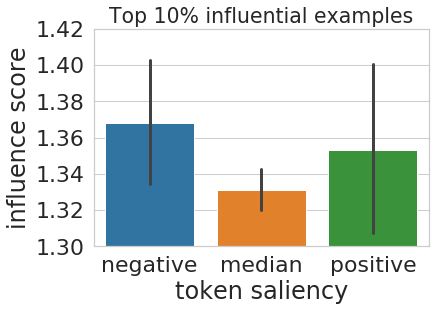

1.3679407633826273
1.3312103047423578
1.3528938298226063
1.3409340958449467
1.3466823076870915

0.03498456652532415
0.011537892789365825
0.043923814087116146
0.01228818881808058
0.01622642949669179


In [15]:
sub_top_percentage = 0.1

idx_range = range(1, 31)
sub_mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, sub_top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
#         mean_ranks_lists[i].append(mean_rank)
        sub_mean_ranks_lists[i].extend(mean_rank)
    
sns.set_style("whitegrid")
with sns.plotting_context("notebook", font_scale=2):
    ax1 = sns.barplot(x=["negative"]*len(sub_mean_ranks_lists[0])+["median"]*len(sub_mean_ranks_lists[1])+["positive"]*len(sub_mean_ranks_lists[2]),
                  y=sub_mean_ranks_lists[0]+sub_mean_ranks_lists[1]+sub_mean_ranks_lists[2], ci=68, errwidth=3)
with sns.plotting_context("notebook", font_scale=1.7):
    plt.title("Top 10% influential examples")
ax1.set_ylabel('influence score')
ax1.set_xlabel('token saliency')
ax1.set(ylim=(1.3, 1.42)) # control for y-lim
plt.show()

print(np.mean(sub_mean_ranks_lists[0]))
print(np.mean(sub_mean_ranks_lists[1]))
print(np.mean(sub_mean_ranks_lists[2]))
print(np.mean(sub_mean_ranks_lists[3]))
print(np.mean(sub_mean_ranks_lists[4]))
print()
print(stats.sem(sub_mean_ranks_lists[0]))
print(stats.sem(sub_mean_ranks_lists[1]))
print(stats.sem(sub_mean_ranks_lists[2]))
print(stats.sem(sub_mean_ranks_lists[3]))
print(stats.sem(sub_mean_ranks_lists[4]))

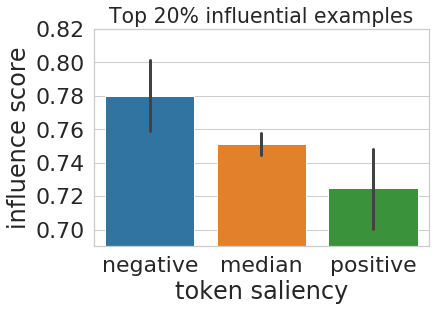

0.7799100846567919
0.7514486142370277
0.7249155441887948
0.7544830484284388
0.7502630908836175

0.02094145313619289
0.006759219348684664
0.024894088967969224
0.007177558128928674
0.009426236117761484


In [16]:
sub_top_percentage = 0.2

idx_range = range(1, 31)
sub_mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, sub_top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
#         mean_ranks_lists[i].append(mean_rank)
        sub_mean_ranks_lists[i].extend(mean_rank)
    
sns.set_style("whitegrid")
with sns.plotting_context("notebook", font_scale=2):
    ax1 = sns.barplot(x=["negative"]*len(sub_mean_ranks_lists[0])+["median"]*len(sub_mean_ranks_lists[1])+["positive"]*len(sub_mean_ranks_lists[2]),
                  y=sub_mean_ranks_lists[0]+sub_mean_ranks_lists[1]+sub_mean_ranks_lists[2], ci=68, errwidth=3)
with sns.plotting_context("notebook", font_scale=1.7):
    plt.title("Top 20% influential examples")
ax1.set_ylabel('influence score')
ax1.set_xlabel('token saliency')
ax1.set(ylim=(0.69, 0.82)) # control for y-lim
plt.show()

print(np.mean(sub_mean_ranks_lists[0]))
print(np.mean(sub_mean_ranks_lists[1]))
print(np.mean(sub_mean_ranks_lists[2]))
print(np.mean(sub_mean_ranks_lists[3]))
print(np.mean(sub_mean_ranks_lists[4]))
print()
print(stats.sem(sub_mean_ranks_lists[0]))
print(stats.sem(sub_mean_ranks_lists[1]))
print(stats.sem(sub_mean_ranks_lists[2]))
print(stats.sem(sub_mean_ranks_lists[3]))
print(stats.sem(sub_mean_ranks_lists[4]))

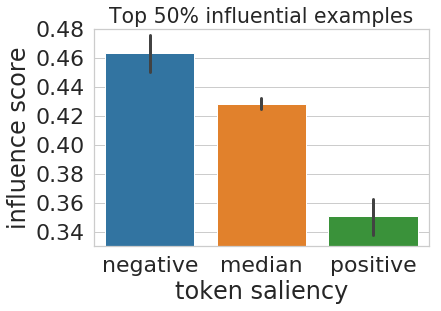

0.463120223057305
0.4284274952549723
0.35092238044273494
0.41368863718100884
0.41271183507238274

0.013286516986632963
0.00407116725407513
0.012684358268062204
0.004154810356673599
0.0054913051990994


In [17]:
sub_top_percentage = 0.5

idx_range = range(1, 31)
sub_mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, sub_top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
#         mean_ranks_lists[i].append(mean_rank)
        sub_mean_ranks_lists[i].extend(mean_rank)
    
sns.set_style("whitegrid")
with sns.plotting_context("notebook", font_scale=2):
    ax1 = sns.barplot(x=["negative"]*len(sub_mean_ranks_lists[0])+["median"]*len(sub_mean_ranks_lists[1])+["positive"]*len(sub_mean_ranks_lists[2]),
                  y=sub_mean_ranks_lists[0]+sub_mean_ranks_lists[1]+sub_mean_ranks_lists[2], ci=68, errwidth=3)
with sns.plotting_context("notebook", font_scale=1.7):
    plt.title("Top 50% influential examples")
ax1.set_ylabel('influence score')
ax1.set_xlabel('token saliency')
ax1.set(ylim=(0.33, 0.48)) # control for y-lim
plt.show()

print(np.mean(sub_mean_ranks_lists[0]))
print(np.mean(sub_mean_ranks_lists[1]))
print(np.mean(sub_mean_ranks_lists[2]))
print(np.mean(sub_mean_ranks_lists[3]))
print(np.mean(sub_mean_ranks_lists[4]))
print()
print(stats.sem(sub_mean_ranks_lists[0]))
print(stats.sem(sub_mean_ranks_lists[1]))
print(stats.sem(sub_mean_ranks_lists[2]))
print(stats.sem(sub_mean_ranks_lists[3]))
print(stats.sem(sub_mean_ranks_lists[4]))

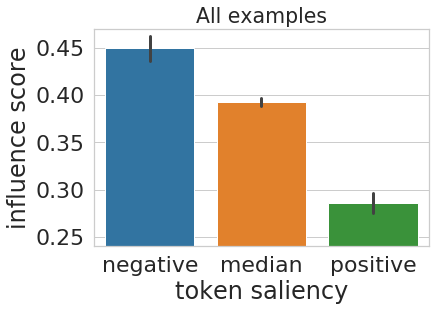

0.44931761367136075
0.3928103213035693
0.2858557200809954
0.367106956569791
0.3690487609536439

0.013307683861266522
0.003929690886221716
0.010610932484122537
0.003904856041833001
0.005133780114012762


In [18]:
sub_top_percentage = 1.0

idx_range = range(1, 31)
sub_mean_ranks_lists = [[], [], [], [], []]
for iti in idx_range:
    mean_ranks = direct_consistency(iti, sub_top_percentage)
    for i, mean_rank in enumerate(mean_ranks):
#         mean_ranks_lists[i].append(mean_rank)
        sub_mean_ranks_lists[i].extend(mean_rank)
    
sns.set_style("whitegrid")
with sns.plotting_context("notebook", font_scale=2):
    ax1 = sns.barplot(x=["negative"]*len(sub_mean_ranks_lists[0])+["median"]*len(sub_mean_ranks_lists[1])+["positive"]*len(sub_mean_ranks_lists[2]),
                  y=sub_mean_ranks_lists[0]+sub_mean_ranks_lists[1]+sub_mean_ranks_lists[2], ci=68, errwidth=3)
with sns.plotting_context("notebook", font_scale=1.7):
    plt.title("All examples")
ax1.set_ylabel('influence score')
ax1.set_xlabel('token saliency')
ax1.set(ylim=(0.24, 0.47)) # control for y-lim
plt.show()

print(np.mean(sub_mean_ranks_lists[0]))
print(np.mean(sub_mean_ranks_lists[1]))
print(np.mean(sub_mean_ranks_lists[2]))
print(np.mean(sub_mean_ranks_lists[3]))
print(np.mean(sub_mean_ranks_lists[4]))
print()
print(stats.sem(sub_mean_ranks_lists[0]))
print(stats.sem(sub_mean_ranks_lists[1]))
print(stats.sem(sub_mean_ranks_lists[2]))
print(stats.sem(sub_mean_ranks_lists[3]))
print(stats.sem(sub_mean_ranks_lists[4]))